# Debug Create Movie Pipeline (Low Memory)

This notebook breaks down the optimized `create_movie.py` pipeline.
Pipeline: Load (Per Channel) -> Stats -> BG Sub -> Norm & 8-bit -> Slab MIPs (2D) -> Blend Mips -> Assemble.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pprint
from types import SimpleNamespace
from pathlib import Path

if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())

import create_movie

In [2]:
# 1. Configuration
args = SimpleNamespace(
    input_dir="/clusterfs/vast/abcabc/Korra_Foundation/20250805_mem-histone/fish1_24hpf/Chromatic_Shift_Corrected/Unmixed/matlab_stitch_no_xcorr/DSR/Cropped/",          # Change this to your path
    output="debug_movie.mp4",
    slab_size=10,
    num_slabs=None,
    voxel_size=[0.108, 0.108, 0.108],
    contrast_percentiles=[1, 99],
    background_offset=0.0,
    gamma=1.0,
    mock=True                # Set False for real data
)

In [3]:
# 2. Discovery
timeline = []
if args.mock:
    print("Generating MOCK timeline...")
    for t in range(0, 500, 100):
        timeline.append({
            'time_msec': t,
            'channels': [
                {'cam': 'CamA', 'ch': 'ch0', 'full_path': 'mock_path_A'},
                {'cam': 'CamB', 'ch': 'ch1', 'full_path': 'mock_path_B'}
            ]
        })
else:
    print(f"Scanning {args.input_dir}...")
    timeline = create_movie.discover_and_group_files(args.input_dir)

print(f"Found {len(timeline)} timepoints.")
bleaching_history = [[] for _ in range(len(timeline[0]['channels']))] if timeline else []

Generating MOCK timeline...
Found 5 timepoints.


In [4]:
# 3. Select Timepoint & Show Metadata
t_idx = 1
if t_idx < len(timeline):
    item = timeline[t_idx]
    start_time_msec = timeline[0]['time_msec']
    rel_msec = item['time_msec'] - start_time_msec
    time_str = create_movie.format_msec(rel_msec)
    
    print(f"Processing Timepoint Index: {t_idx}")
    print(f"Absolute Time: {item['time_msec']} ms")
    print(f"Relative Time: {time_str}")
    print("\nItem Metadata:")
    pprint.pprint(item)

Processing Timepoint Index: 1
Absolute Time: 100 ms
Relative Time: 00:00:00

Item Metadata:
{'channels': [{'cam': 'CamA', 'ch': 'ch0', 'full_path': 'mock_path_A'},
              {'cam': 'CamB', 'ch': 'ch1', 'full_path': 'mock_path_B'}],
 'time_msec': 100}


## 4. Load & Process Per Channel
Loads, subtracts background, normalizes to 8-bit, and immediately computes 2D slabs.

Processing CamA_ch0...
  Load: 0.002s | Shape: (50, 100, 100)
  BG/Stats: 0.002s
  Norm: 0.010s
  Slabs: 0.000s | Count: 5
Processing CamB_ch1...
  Load: 0.003s | Shape: (50, 100, 100)
  BG/Stats: 0.002s
  Norm: 0.011s
  Slabs: 0.000s | Count: 5


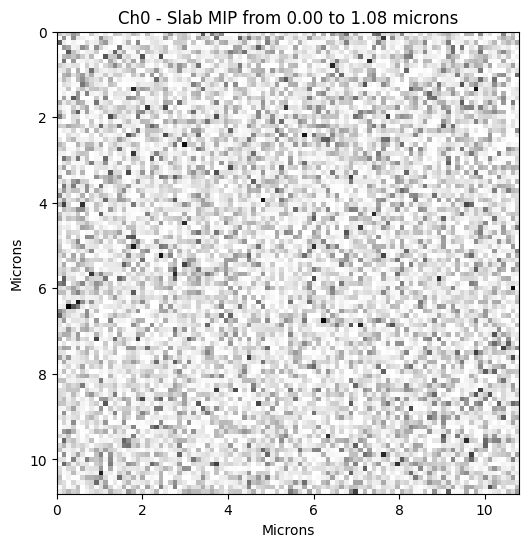

In [5]:
processed_volumes = []
raw_sums = []
channel_slabs_list = []

for f_meta in item['channels']:
    try:
        print(f"Processing {f_meta['cam']}_{f_meta['ch']}...")
        # Load
        t0 = time.time()
        vol = create_movie.load_zarr_data(f_meta['full_path'], mock=args.mock)
        print(f"  Load: {time.time() - t0:.3f}s | Shape: {vol.shape}")
        
        # BG Sub (float) & Stats
        t0 = time.time()
        vol_bg = vol.astype(np.float32) - args.background_offset
        vol_bg[vol_bg < 0] = 0
        raw_sums.append(np.sum(vol_bg))
        print(f"  BG/Stats: {time.time() - t0:.3f}s")
        
        # Norm -> 8-bit
        t0 = time.time()
        vol_norm = create_movie.normalize_volume(vol_bg, args.contrast_percentiles[0], args.contrast_percentiles[1], args.gamma)
        processed_volumes.append(vol_norm)
        print(f"  Norm: {time.time() - t0:.3f}s")
        
        # Compute Slabs (Single Channel)
        t0 = time.time()
        slabs = create_movie.create_slabs_mip(vol_norm, slab_size=args.slab_size, num_slabs=args.num_slabs)
        channel_slabs_list.append(slabs)
        print(f"  Slabs: {time.time() - t0:.3f}s | Count: {len(slabs)}")
        
    except Exception as e:
        print(f"Error: {e}")

# Mock history update
if len(bleaching_history[0]) <= t_idx:
    for i, val in enumerate(raw_sums):
        bleaching_history[i] = [val] * (t_idx + 1)

# Visual Check: First slab of first channel
if channel_slabs_list:
    plt.figure(figsize=(6,6))
    
    # Display with micron axes
    img = channel_slabs_list[0][0]
    h, w = img.shape
    # args.voxel_size is [z, y, x]
    dy = args.voxel_size[1]
    dx = args.voxel_size[2]
    extent = [0, w*dx, h*dy, 0]
    
    # Calculate Z range for Slab 0
    z_res = args.voxel_size[0]
    s_idx = 0
    z_start = s_idx * args.slab_size * z_res
    z_end = (s_idx + 1) * args.slab_size * z_res
    
    plt.imshow(img, cmap='gray', extent=extent)
    plt.title(f"Ch0 - Slab MIP from {z_start:.2f} to {z_end:.2f} um")
    plt.xlabel("Microns")
    plt.ylabel("Microns")
    plt.show()

## 5. Blend & Arrange MIPs
Combine per-channel slabs into RGB MIPs.

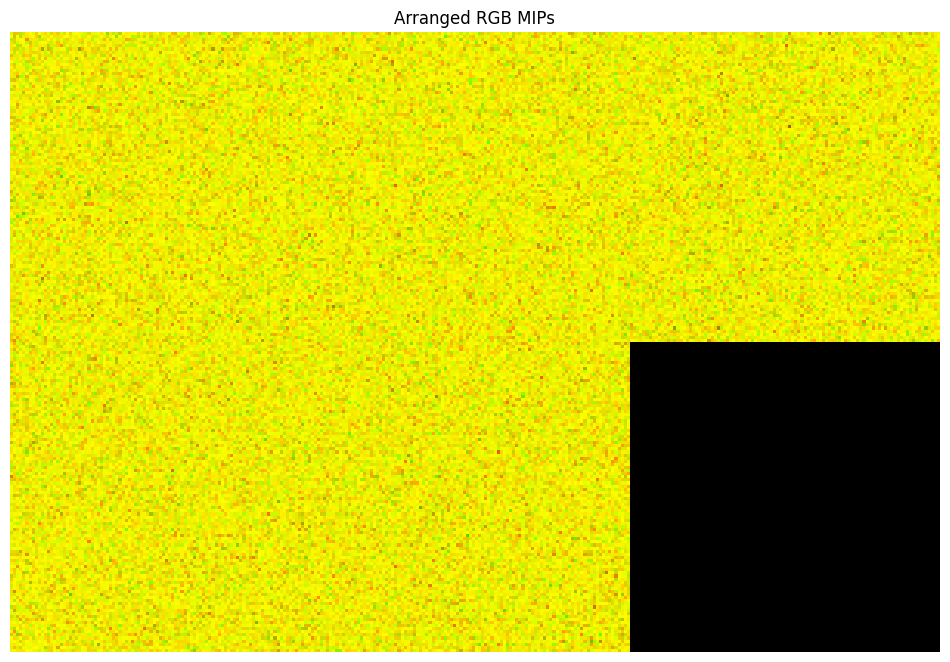

In [6]:
final_rgb_mips = []
if channel_slabs_list:
    num_generated_slabs = len(channel_slabs_list[0])
    for s_i in range(num_generated_slabs):
        # Gather slabs for this index
        slabs_to_blend = []
        for ch_slabs in channel_slabs_list:
            if s_i < len(ch_slabs):
                slabs_to_blend.append(ch_slabs[s_i])
            else:
                 slabs_to_blend.append(None)
        
        rgb_slab = create_movie.blend_channel_mips(slabs_to_blend, item['channels'])
        final_rgb_mips.append(rgb_slab)

# Arrange with borders
mips_img, grid_geom = create_movie.arrange_mips(final_rgb_mips, args.voxel_size, border_width=2)
rows, cols, cell_h, cell_w = grid_geom

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(mips_img)
ax.set_title("Arranged RGB MIPs")
ax.axis('off')

# Add Labels
if processed_volumes and final_rgb_mips:
    z_dim = processed_volumes[0].shape[0]
    edges = create_movie.get_slab_edges(z_dim, args.slab_size, args.num_slabs)
    z_res = args.voxel_size[2]
    
    for s_idx in range(len(final_rgb_mips)):
        if s_idx < len(edges) - 1:
            z_start = edges[s_idx] * z_res
            z_end = edges[s_idx+1] * z_res
            
            r = s_idx // cols
            c_idx = s_idx % cols
            
            text_x = c_idx * cell_w + cell_w / 2
            text_y = r * cell_h + 15
            
            ax.text(text_x, text_y, f"{z_start:.1f}-{z_end:.1f} µm", 
                    color='white', ha='center', va='top', fontsize=8, 
                    bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
plt.show()

## 6. FFT Analysis
Using the kept 8-bit volumes (summed).

In [ ]:
# 6. FFT Analysis
from matplotlib.colors import LogNorm

if processed_volumes:
    sum_vol = np.sum(np.array(processed_volumes), axis=0)
    # Compute Norm FFT
    f_xy, f_xz, f_yz = create_movie.compute_fft_planes_norm(sum_vol)
    
    # Extents (Fixed to -1, 1)
    ext_xy, ext_xz, ext_yz = create_movie.get_fft_extent(args.voxel_size, sum_vol.shape)
    
    # Setup Figure
    # Adjust spacing for "closer" plots using gridspec pars 
    fig = plt.figure(figsize=(8, 8))
    gs = fig.add_gridspec(2, 2, wspace=0.05, hspace=0.05)

    # Layout: L-shape
    # [ XY ] [ YZ ]
    # [ XZ ] [    ]
    
    ax_xy = fig.add_subplot(gs[0, 0])
    ax_yz = fig.add_subplot(gs[0, 1])
    ax_xz = fig.add_subplot(gs[1, 0])
    
    k_label = r"$k / (4\pi n / \lambda_{exc})$"
    
    # XY
    im = ax_xy.imshow(f_xy, cmap='jet', extent=ext_xy, 
                      norm=LogNorm(vmin=0.01, vmax=1), origin='lower')
    ax_xy.set_ylabel("ky")
    ax_xy.set_xticklabels([])
    
    # YZ (Transposed to match ky vertical)
    ax_yz.imshow(f_yz.T, cmap='jet', extent=ext_yz, 
                 norm=LogNorm(vmin=0.01, vmax=1), origin='lower')
    ax_yz.set_xlabel("kz")
    ax_yz.set_yticklabels([]) # Shared Y with XY visually
    
    # XZ
    ax_xz.imshow(f_xz, cmap='jet', extent=ext_xz, 
                 norm=LogNorm(vmin=0.01, vmax=1), origin='lower')
    ax_xz.set_xlabel("kx")
    ax_xz.set_ylabel("kz")
    
    # Colorbar
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    div = make_axes_locatable(ax_yz)
    cax = div.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    
    plt.show()

## 7. Bleaching Stats

In [ ]:
plt.figure(figsize=(6, 4))
times = [x['time_msec'] for x in timeline[:t_idx+1]]
for c_i, hist in enumerate(bleaching_history):
    if len(hist) > 0:
        norm_vals = np.array(hist) / hist[0] if hist[0] > 0 else np.array(hist)
        plt.plot(times, norm_vals[:len(times)], label=f"Ch{c_i}")
plt.legend()
plt.title("Bleaching (Integrated Intensity)")
plt.show()

## 8. Final Frame Assembly

In [ ]:
from matplotlib.colors import LogNorm

# 8. Final Frame Assembly (4K, Red Scale Bar 1st Panel, TL Labels)
# 3840x2160 pixels. At 100 dpi -> 38.4 x 21.6 inches.
fig = plt.figure(figsize=(38.4, 21.6), dpi=100)

# Main Layout
gs_main = fig.add_gridspec(1, 2, width_ratios=[6, 1], wspace=0.02)

# Left: MIPs
ax_mips = fig.add_subplot(gs_main[0])
ax_mips.axis('off')
if 'mips_img' in locals() and mips_img is not None:
    ax_mips.imshow(mips_img)
    
    # Title with Frame Count
    frame_str = f"Frame: {t_idx if 't_idx' in locals() else 0}"
    time_val = time_str if 'time_str' in locals() else '00:00:00'
    ax_mips.set_title(f"Time: {time_val} | {frame_str}", fontsize=24)
    
    # Z-range Labels (Top Left)
    if 'processed_volumes' in locals() and processed_volumes and 'grid_geom' in locals():
        z_dim = processed_volumes[0].shape[0]
        edges = create_movie.get_slab_edges(z_dim, args.slab_size, args.num_slabs)
        z_res = args.voxel_size[2]
        
        rows, cols, cell_h, cell_w = grid_geom
        
        num_tiles = len(edges) - 1
        for s_idx in range(num_tiles):
            z_start = edges[s_idx] * z_res
            z_end = edges[s_idx+1] * z_res
            r = s_idx // cols
            c_idx = s_idx % cols
            # Left edge + offset
            text_x = c_idx * cell_w + 40
            text_y = r * cell_h + 40 
            ax_mips.text(text_x, text_y, f"{z_start:.1f}-{z_end:.1f} µm", 
                         color='white', ha='left', va='top', fontsize=24, 
                         bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
        
        # Scale Bar (Red, Bottom Left of FIRST Slab)
        if args.voxel_size[0] > 0:
            bar_len_um = 10
            bar_len_px = bar_len_um / args.voxel_size[0]
            if bar_len_px < mips_img.shape[1]:
                # First slab is r=0, c=0.
                # Bottom left of first slab is approx (0, cell_h)
                # We place it with padding.
                bar_x = 40
                bar_y = cell_h - 40
                
                rect = plt.Rectangle((bar_x, bar_y), 
                                     bar_len_px, 15, color='red')
                ax_mips.add_patch(rect)
                
                # Text above bar (Red)
                ax_mips.text(bar_x + bar_len_px/2, bar_y - 30, 
                             f"{bar_len_um} µm", color='red', ha='center', va='bottom', fontsize=24)

# Right: Sidebar
gs_side = gs_main[1].subgridspec(4, 1, hspace=0.15)
ax_fft_xy = fig.add_subplot(gs_side[0])
ax_fft_yz = fig.add_subplot(gs_side[1])
ax_fft_xz = fig.add_subplot(gs_side[2])
ax_bleach = fig.add_subplot(gs_side[3])

# FFT
if 'processed_volumes' in locals() and processed_volumes:
    sum_vol = np.sum(np.array(processed_volumes), axis=0)
    f_xy, f_xz, f_yz = create_movie.compute_fft_planes_norm(sum_vol)
    ext_xy, ext_xz, ext_yz = create_movie.get_fft_extent(args.voxel_size, sum_vol.shape)
    k_label = r"$k / (4\pi n / \lambda_{exc})$"
    
    ax_fft_xy.imshow(f_xy, cmap='jet', extent=ext_xy, norm=LogNorm(vmin=0.01, vmax=1), origin='lower')
    ax_fft_xy.set_ylabel("ky")
    ax_fft_xy.set_xticklabels([])
    ax_fft_xy.set_aspect('auto')

    ax_fft_yz.imshow(f_yz.T, cmap='jet', extent=ext_yz, norm=LogNorm(vmin=0.01, vmax=1), origin='lower')
    ax_fft_yz.set_ylabel("ky")
    ax_fft_yz.set_xticklabels([])
    ax_fft_yz.set_aspect('auto')

    ax_fft_xz.imshow(f_xz, cmap='jet', extent=ext_xz, norm=LogNorm(vmin=0.01, vmax=1), origin='lower')
    ax_fft_xz.set_xlabel(k_label)
    ax_fft_xz.set_ylabel("kz")
    ax_fft_xz.set_aspect('auto')

# Bleaching
if 'bleaching_history' in locals() and 'timeline' in locals():
    t_idx_local = t_idx if 't_idx' in locals() else 0
    times = [x['time_msec'] for x in timeline[:t_idx_local+1]]
    for c_i, hist in enumerate(bleaching_history):
        if len(hist) > 0:
            current_hist = hist[:len(times)]
            if len(current_hist) > 0:
                norm_vals = np.array(current_hist) / hist[0] if hist[0] > 0 else np.array(current_hist)
                ax_bleach.plot(times, norm_vals, label=f"Ch{c_i}")
    ax_bleach.set_title("Bleaching")
    ax_bleach.set_xlabel("Time (ms)")

plt.show()